In [47]:
from pathlib import Path
import pickle
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns

import utils
from utils import names
from utils.experiments import (
	features, run_experiment, get_labeled_data, results_all_samplers,
	results_for_sampler, combinations
)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def get_coeffs(X, y, tries, model_fn):
	model = make_pipeline(StandardScaler(), model_fn())
	X = X.reshape((len(X), -1))
	results = np.empty((X.shape[1]+1, tries))
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for i, (train, test) in enumerate(splits):
		reg = model.fit(X[train], y[train])[1]
		results[:,i] = np.insert(reg.coef_, 0, model.score(X[test], y[test]))
	return results

files = [*nb_utils.get_files(1, sampler="Random")][0]
res = get_coeffs(*get_labeled_data(1, files), 1000, LinearRegression)
r2s, coeffs = res[0], res[1:]
r2s.mean()

NameError: name 'nb_utils' is not defined

In [31]:
feat = np.repeat(*zip(*features.items()))

In [32]:
feat

array(['avg_birth_death', 'avg_birth_death', 'avg_birth_death_squared',
       'avg_birth_death_squared', 'avg_birth_death_inverted',
       'avg_birth_death_inverted', 'std_birth_death', 'std_birth_death',
       'avg_life', 'avg_life_squared', 'avg_half_life',
       'avg_half_life_squared'], dtype='<U24')

In [21]:
coeffs.reshape((2,-1))

array([[ 0.        ,  0.        ,  0.        , ..., -0.29553614,
        -0.2843982 , -0.21688009],
       [-0.28986563, -0.87091244, -0.24271589, ...,  0.5108818 ,
         0.65689634,  0.43468028]])

In [2]:
feats = feat
for i, f in enumerate(feats):
	if 'birth' in f:
		feats[i] = f.replace('_birth', '') if i % 2 else f.replace('_death', '')
hm = coeffs.mean(axis=1).reshape((2,-1))
maxval = np.abs(hm).max()
norm = colors.Normalize(-maxval, maxval)
fig, ax = plt.subplots()
im, _ = utils.heatmap(hm, [0, 1], feats,
						ax=ax, cmap='PuOr', norm=norm)
utils.annotate_heatmap(im, threshold=0.3)
fig.tight_layout()

NameError: name 'feat' is not defined

In [227]:
from sklearn.linear_model import Lasso

files = [*nb_utils.get_files(1, sampler="Random")][0]
X, y = get_labeled_data(1, files)
means = np.zeros(50)
for i, alpha in enumerate(np.logspace(0.001,100)):
	means[i] = run_experiment(X, y, [slice(0, None)], 200, lambda: Lasso(alpha)).mean()

100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


In [228]:
means

array([-0.05723672, -0.06181788, -0.06382442, -0.06036992, -0.0568762 ,
       -0.05196619, -0.05102436, -0.05588033, -0.06318991, -0.04615091,
       -0.06873296, -0.0615679 , -0.06395212, -0.05736377, -0.07559715,
       -0.05684296, -0.05732924, -0.06210013, -0.05569562, -0.06890401,
       -0.05615766, -0.05638735, -0.07436018, -0.06585849, -0.07157852,
       -0.05351006, -0.05879681, -0.05575278, -0.05724428, -0.05999818,
       -0.06219286, -0.06458854, -0.06447209, -0.05906657, -0.06323985,
       -0.05341267, -0.05704421, -0.06639216, -0.06765642, -0.06073857,
       -0.06213707, -0.0675968 , -0.06005939, -0.06792763, -0.06280278,
       -0.06011825, -0.07353906, -0.05158658, -0.05637914, -0.05467553])

## Model performance
We look at the model performance for the model with the best performing selection of features (by average R2) and at the models incorporating all features

In [6]:
def extract_best(results, ):
	return max(results, key=np.mean)

def extract_all(results):
	return results[-1]

In [86]:
def filter_results(results, samplers, fn=lambda x: x):
	return zip(*((res, s) for res, s in zip(results, samplers) if fn(s)))

In [90]:
results, samplers = filter_results(*results_all_samplers(1), lambda x: '-' not in x)

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results],
	'Best features': [np.mean(extract_best(res)) for res in results]
}, index=map(names.samplers.get, samplers))

,All features,Best features
Importance ($\mu$),0.606526,0.718931
Importance (max),0.723637,0.788833
Random,0.771025,0.815547
Filter correlation,0.756973,0.793958
K-means++,0.780958,0.824686
Random (s),0.746796,0.796928
Importance (zero),0.360134,0.462570


In [11]:
feature_ix = {
	f: list(features.keys()).index(f) for f in features
}
counters = np.zeros((len(features)))
for exp in results[samplers.index('Random')].T:
	ixs = [feature_ix[f] for f in combinations[np.argmax(exp)]]
	counters[ixs] += 1


In [12]:
len(features)

8

In [13]:
len(combinations)

255

### KDE plots

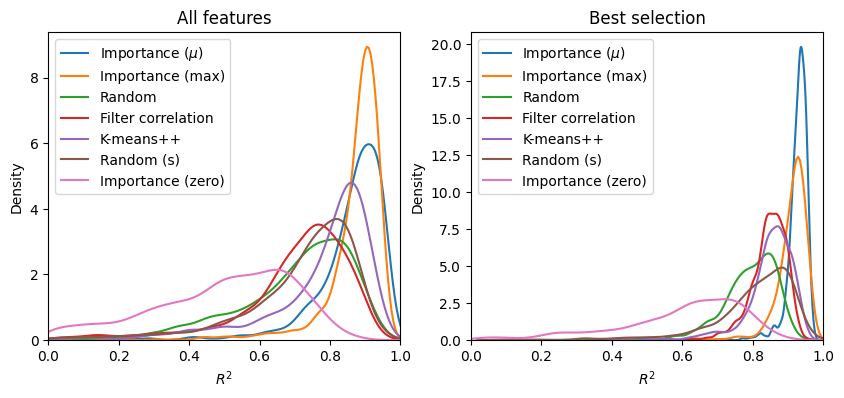

In [62]:
reload(utils.names)

def plot_kdes(results, samplers=None, bw=0.2, figsize=(10, 4)):
	fig, axs = plt.subplots(1, 2, figsize=figsize)
	types = {'All features': extract_all, 'Best selection': extract_best}
	for ax, (title, extract) in zip(axs, types.items()):
		dists = [extract(results) for results in results]
		for i, dist in enumerate(dists):
			label = ''
			if samplers:
				# name = names.samplers[samplers[i]]
				# label = name + f' ({dist.mean():.2f})'
				label = names.samplers[samplers[i]]
			dist = dist[dist > 0]
			ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=label)
		if samplers:
			ax.legend()
		ax.set_xlabel('$R^2$')
		ax.set_xlim([0,1])
		ax.set_title(title)
	return fig, axs

plot_kdes(results, samplers, bw=0.2)
plt.savefig('results/figures/task1_kde_all.pdf', bbox_inches='tight')

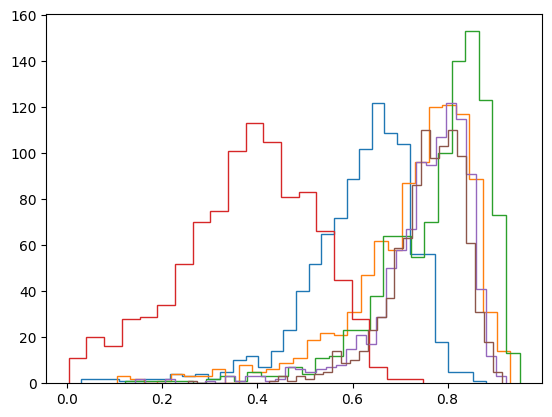

In [15]:
for res in results[:,-1]:
	plt.hist(res[res>=0], bins='auto', histtype='step')

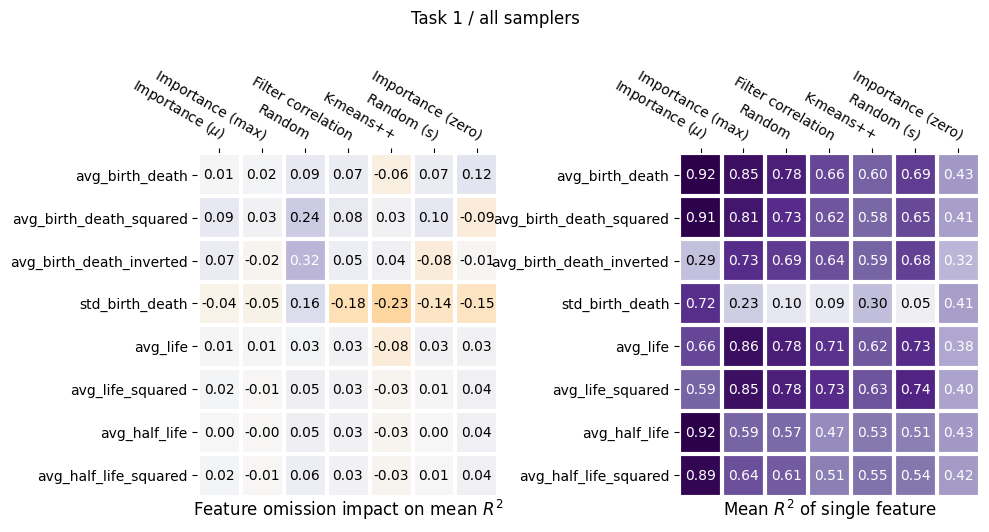

In [60]:
def heatmap_r2(results, samplers=None, wspace=0.6):
	one_removed_r2s = np.mean(results[:,-2:-len(features)-2:-1], axis=2)
	heatmaps = [
		one_removed_r2s - np.mean(results[:,[-1]], axis=2),
		np.mean(results[:,:len(features)], axis=2)
	]

	fig, axs = plt.subplots(1, 2, figsize=(10, 6))
	titles = [
		"Feature omission impact on mean $R^2$",
		"Mean $R^2$ of single feature"
	]

	maxval = np.abs(heatmaps).max()
	norm = colors.Normalize(-maxval, maxval)
	for i in 0, 1:
		im, _ = utils.heatmap(heatmaps[i].T, features.keys(), samplers,
								ax=axs[i], cmap='PuOr', norm=norm)
		utils.annotate_heatmap(im, threshold=0.3)
		axs[i].set_title(titles[i], y=-0.08)

	fig.tight_layout()
	plt.subplots_adjust(wspace=wspace)
	return fig, axs

fig, _ = heatmap_r2(results, [names.samplers[s] for s in samplers], wspace=0.6)
fig.suptitle('Task 1 / all samplers')
plt.show()

In [18]:
def best_selection_table(results, samplers=None):
	data = [
		[f in combinations[np.argmax(np.mean(res, 1))] for f in features]
		for res in results
	]
	data = dict(zip(samplers, data)) if samplers else np.transpose(data)
	return pd.DataFrame(data, index=features.keys()).replace({True: 'X', False: ''})

best_selection_table(results, samplers)

,AvgImportance,MaxImportance,Random,ZeroImportance,StratifiedRandom,StratifiedFilterCorr
avg_birth_death,,X,X,,,
avg_birth_death_squared,X,,,X,X,X
avg_birth_death_inverted,,X,X,X,X,X
std_birth_death,X,X,X,X,X,X
avg_life,X,X,X,,X,X
avg_life_squared,,X,,,,
avg_half_life,X,,,,,
avg_half_life_squared,,X,X,,X,X


In [23]:
results_random = np.array([
	results_for_sampler(1, files)
	for files in utils.get_files(1, sampler='Random')
])

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results_random],
	'Best features': [np.mean(extract_best(res)) for res in results_random]
})

,All features,Best features
0,0.771025,0.815547
1,0.821280,0.847617
2,0.757166,0.814416
3,0.716123,0.796214


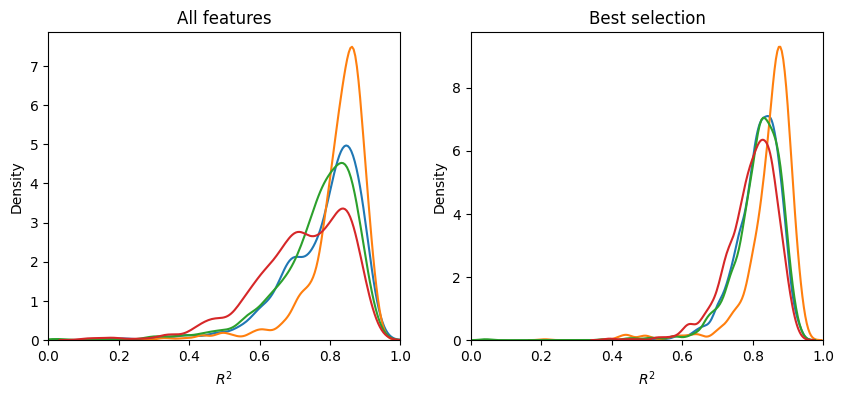

In [24]:
plot_kdes(results_random, bw=0.2)
plt.show()

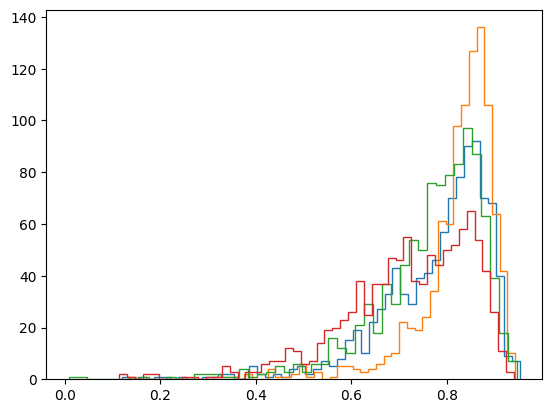

In [25]:
for res in np.array(results_random)[:,-1]:
	plt.hist(res[res>=0], bins=50, histtype='step')

In [26]:
best_selection_table(results_random)

,0,1,2,3
avg_birth_death,X,,,X
avg_birth_death_squared,,X,,
avg_birth_death_inverted,X,X,X,X
std_birth_death,X,X,X,X
avg_life,X,X,X,
avg_life_squared,,X,,
avg_half_life,,,X,
avg_half_life_squared,X,,X,X


In [27]:
results, samplers = results_all_samplers(2)
pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results],
	'Best features': [np.mean(extract_best(res)) for res in results]
}, index=samplers)

,All features,Best features
AvgImportance,0.804729,0.928600
MaxImportance,0.856164,0.906139
Random,0.305313,0.793242
StratifiedFilterCorr,0.673733,0.843850
StratifiedKMeans20000,0.762301,0.850927
StratifiedRandom,0.678292,0.802370
ZeroImportance,0.397299,0.567273


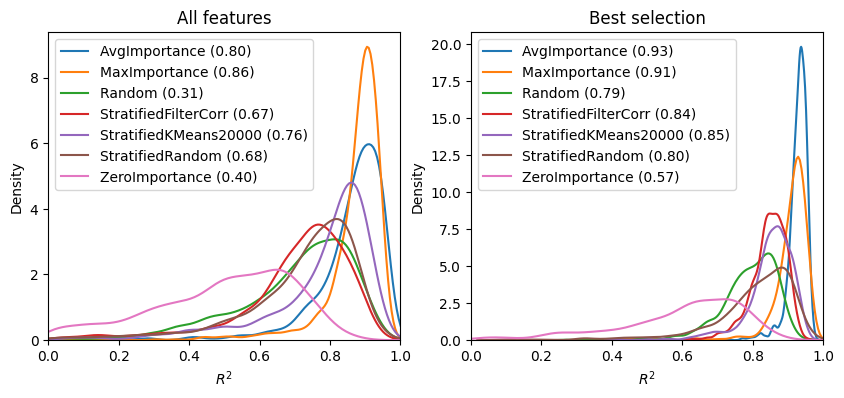

In [28]:
plot_kdes(results, samplers)
plt.show()

In [29]:
best_selection_table(results, samplers)

,AvgImportance,MaxImportance,Random,StratifiedFilterCorr,StratifiedKMeans20000,StratifiedRandom,ZeroImportance
avg_birth_death,,,,,,,
avg_birth_death_squared,X,X,,,,,X
avg_birth_death_inverted,,X,,X,,X,X
std_birth_death,,X,X,X,X,X,X
avg_life,X,,,,X,X,
avg_life_squared,,,X,,X,X,X
avg_half_life,,X,X,,X,X,X
avg_half_life_squared,,,,,,X,


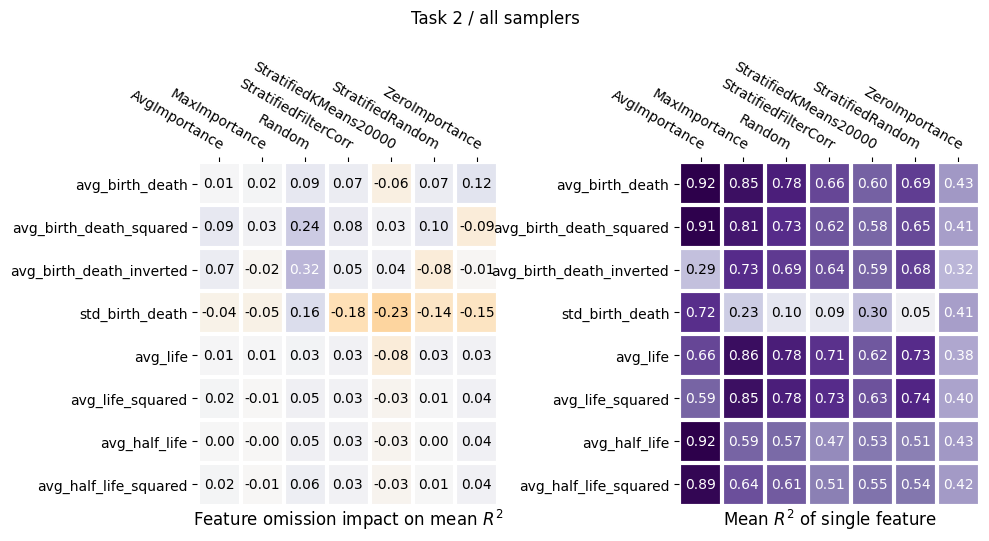

In [30]:
fig, _ = heatmap_r2(results, samplers, wspace=0.6)
fig.suptitle('Task 2 / all samplers')
plt.show()

In [42]:
from importlib import reload
reload(utils)
reload(utils.experiments)

results_avg = np.array([
	results_for_sampler(2, files)
	for files in utils.get_files(2, sampler='AvgImportance')
])

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results_avg],
	'Best features': [np.mean(extract_best(res)) for res in results_avg]
})

Calculating task2/AvgImportance/23.01.05-14.09.03


100%|██████████| 255/255 [06:53<00:00,  1.62s/it]


Calculating task2/AvgImportance/23.01.05-14.32.50


100%|██████████| 255/255 [06:12<00:00,  1.46s/it]


,All features,Best features
0,0.804729,0.928600
1,0.768837,0.925713
2,0.849454,0.941387


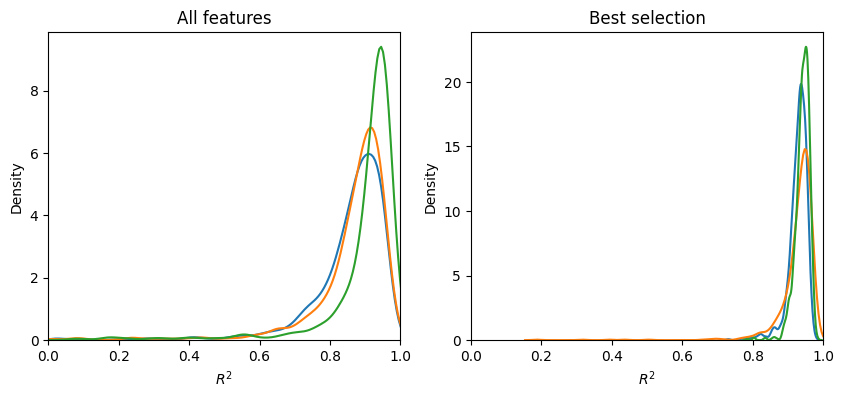

In [63]:
plot_kdes(results_avg, bw=0.2)
plt.show()

In [66]:
best_selection_table(results_avg)

,0,1,2
avg_birth_death,,,
avg_birth_death_squared,X,,X
avg_birth_death_inverted,,X,
std_birth_death,,X,
avg_life,X,X,
avg_life_squared,,,
avg_half_life,,,
avg_half_life_squared,,X,X


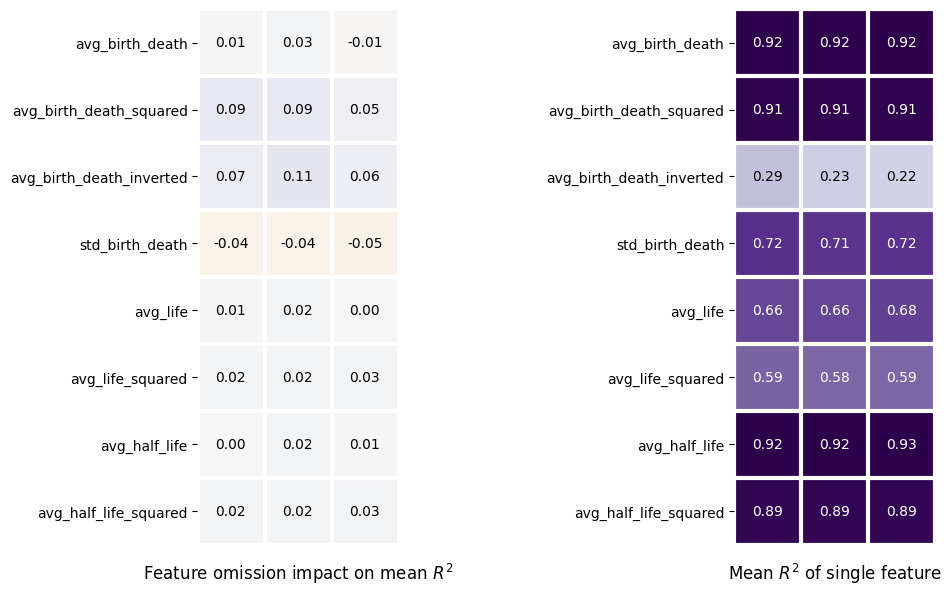

In [68]:
fig, _ = heatmap_r2(results_avg)
plt.show()